# DO NOT CLEAR OUTPUT

In [234]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.backend_bases
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 
from sklearn.compose import make_column_selector

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag # for bagging
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
import eli5 # "explain it to me like I'm 5"
from eli5.sklearn import PermutationImportance

#eda
import pandas_profiling

# Misc
import warnings
warnings.filterwarnings("ignore")

## Explore data

In [10]:
df_19 = pd.read_csv("df_19.csv")

In [11]:
df_19.describe()

,total_mwh,total_cust,no,saidi_nomed,circuits,voltage,gen_mwh,purchase_mwh,pv_mwh,wind_mwh,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh,pv_pct,wind_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
count,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,767.000000,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,7.670000e+02,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,2.877815e+06,1.325098e+05,12300.241199,138.778774,190.542373,47.014342,1.603899e+06,1.562233e+06,1549.682040,85.946874,1643.192293,2.754904e+04,12274.062581,1751.307789,0.063293,0.002523,0.066940,0.368537,0.018130,4.560795
std,8.153767e+06,3.853289e+05,8559.434421,141.224948,475.750289,205.103511,8.019806e+06,4.091160e+06,18568.046351,1827.784027,20219.445852,1.255740e+05,69746.807005,35827.024220,0.496231,0.029555,0.512219,1.061427,0.179930,13.820391
min,2.829000e+03,4.100000e+01,97.000000,0.655000,1.000000,0.000000,-5.120000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.374375e+05,1.095350e+04,5896.000000,55.630000,30.000000,0.000000,0.000000e+00,1.591930e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.314040e+05,2.415200e+04,12268.000000,99.800000,57.000000,0.000000,0.000000e+00,4.425630e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.484748e+06,6.527150e+04,16715.000000,170.259500,123.000000,19.000000,4.650000e+01,1.078380e+06,55.925500,0.000000,65.226500,1.209000e+03,31.500000,0.000000,0.007547,0.000000,0.008335,0.237313,0.000000,0.035619
max,1.119557e+08,5.061483e+06,60839.000000,1239.300000,5619.000000,2787.000000,1.265085e+08,5.667982e+07,466156.237000,49255.057000,515411.294000,2.097423e+06,895133.000000,977215.000000,10.630452,0.758238,10.630452,10.727103,3.509534,100.000000


In [12]:
df_19.sort_values(['gen_mwh']).filter(['name','gen_mwh']).head(2)

,name,gen_mwh
280,City of Homestead - (FL),-512.0
383,"Medina Electric Coop, Inc",0.0


This is kind of weird, there is one utility with a negative gen_mwh: City of Homestead, FL. They do have a positive purchase MWh's value so maybe they use more electricity than they generate and buy the difference? I don't know if I should remove it as an outlier because this is theoretically possible, but it could trip up my model later on.

**Update**: I didn't end up using gen_mwh.

In [13]:
# convert object variables to categories
for col in df_19.select_dtypes(include="object"):
    df_19[col] = df_19[col].astype('category')

In [14]:
df_19.dtypes

name                 category
state                category
total_mwh             float64
total_cust            float64
no                    float64
type                 category
saidi_nomed           float64
saifi_nomed          category
caidi_nomed          category
circuits              float64
voltage               float64
nerc                 category
gen_mwh               float64
purchase_mwh          float64
ba                   category
pv_mwh                float64
wind_mwh              float64
nm_mwh                float64
ee_mwh                float64
dem_res_customers     float64
dem_res_mwh           float64
pv_pct                float64
wind_pct              float64
nm_pct                float64
ee_pct                float64
dem_res_pct           float64
dem_res_cust_pct      float64
dtype: object

In [15]:
y = df_19['saidi_nomed']
X = df_19[['ba','state','type','total_mwh',
           'nerc','gen_mwh','purchase_mwh',
           'circuits','voltage',
           'total_cust','pv_pct',
           'wind_pct','ee_pct',
           'dem_res_pct']]

In [16]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [17]:
print(train_X.shape[0]/df_19.shape[0])
print(test_X.shape[0]/df_19.shape[0])

0.7496740547588006
0.2503259452411995


## Check for multicollinearity

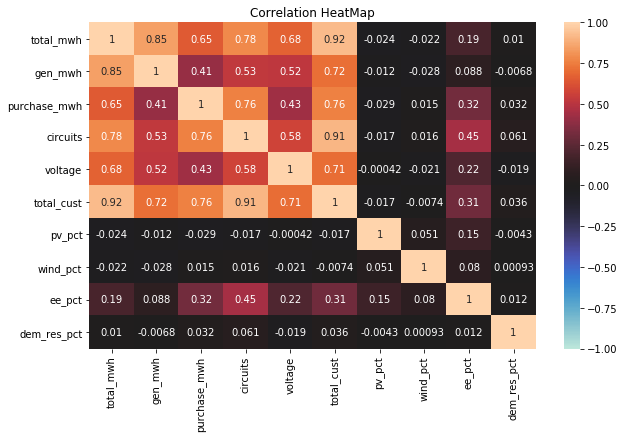

In [18]:
#creating pairwise correlation of columns using Pearson's R,
corr = train_X.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr, annot=True, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

It looks like we have some amount of multicollinearity, specifically between **Circuits** and **total customers** and **voltage** and **total customers**. This makes sense because more customers require more distribution grid support. To solve this, we can probably get rid of total customers. **Net generation mwh** and **purchased mwh** are also highly correlated with **total customers**, but I may not include those two variables anyway because I will probably just use **total mwh sold** which should account for the predictive ability of all those variables.

In [19]:
# standard deviation of training outcome variable
train_y.describe()[2]

146.38788413126352

In [20]:
# take a look at how skewed each variable is
df_19.skew().sort_values(ascending = False)

dem_res_mwh          26.539468
wind_mwh             25.812322
wind_pct             22.522538
nm_mwh               22.415085
pv_mwh               21.715897
pv_pct               16.955033
nm_pct               16.647306
dem_res_pct          14.958544
ee_mwh                9.237866
gen_mwh               8.836816
dem_res_customers     8.622896
voltage               8.609001
total_mwh             6.847969
purchase_mwh          6.847500
total_cust            6.647667
circuits              5.799939
ee_pct                5.537040
dem_res_cust_pct      4.351490
saidi_nomed           3.002114
no                    2.021330
dtype: float64

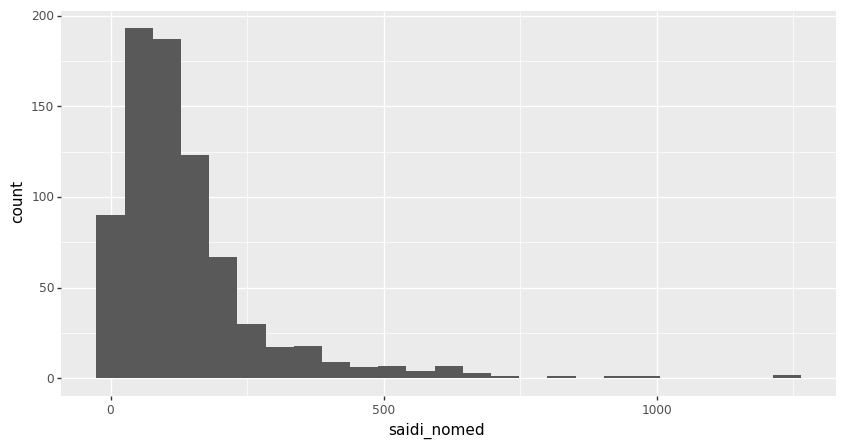

<ggplot: (8771484711857)>

In [129]:
# look at distribution of outcome
(
    ggplot(df_19,aes(x="saidi_nomed")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

# Explore Training Data

In [124]:
df_19

,name,total_mwh,total_cust,no,saidi_nomed,saifi_nomed,caidi_nomed,circuits,voltage,gen_mwh,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,Adams Electric Coop,176102.0,8931.0,97.0,169.740,1.29,131.5814,47.0,47.0,4612.0,...,0,0,0,0,0,0,0,0,0,0
1,Adams-Columbia Electric Coop,515186.0,37607.0,108.0,139.900,0.95,147.26316,95.0,16.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,Agralite Electric Coop,238558.0,5251.0,155.0,128.759,1.181,109.0254,64.0,0.0,447.0,...,0,0,0,0,0,0,0,0,0,0
3,Aiken Electric Coop Inc,938436.0,48059.0,162.0,97.720,.,.,122.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Alaska Electric Light&Power Co,337796.0,17280.0,213.0,79.000,2.08,37.980769,31.0,31.0,123203.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,Ameren Illinois Company,8017902.0,499059.0,56697.0,132.290,0.995,132.95477,2966.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
763,Liberty Utilities,564462.0,48770.0,57483.0,416.510,2.96,140.71284,42.0,0.0,131026.0,...,0,0,0,0,0,0,0,0,0,0
764,PUD No 1 of Jefferson County,376212.0,19742.0,59013.0,291.000,2.04,142.64706,21.0,21.0,0.0,...,0,0,0,0,0,0,1,0,0,0
765,Upper Michigan Energy Resources Corp.,1610240.0,36818.0,60631.0,238.000,1.5,158.66667,57.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Continuous Variables

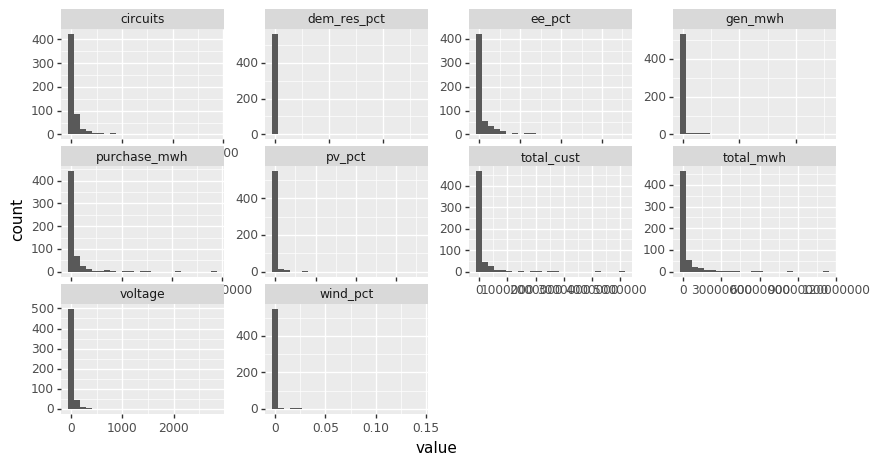

<ggplot: (8765464299017)>

In [476]:
# Plot the continuous variables 
df_num = train_X.select_dtypes(include="number").melt()

(
    ggplot(df_num,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

## Categorical Variables

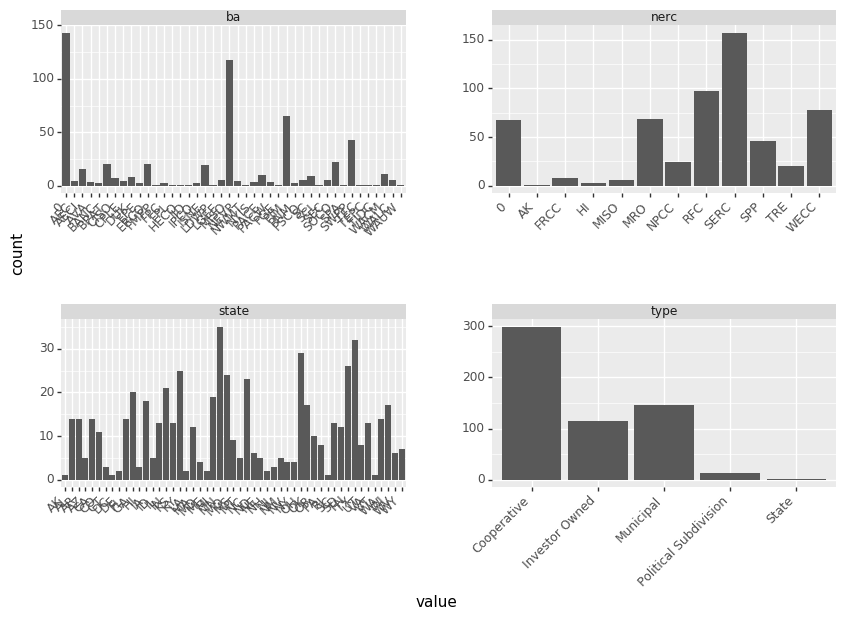

<ggplot: (8765489978709)>

In [458]:
# plot distributions of categorical variables
df_cat = train_X.select_dtypes(include="category").melt()

(
    ggplot(df_cat,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,6),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

### Let's dummify NERC regions, state, and utility type

In [22]:
nerc_dummies = pd.get_dummies(df_19.nerc)

In [23]:
# we'll use None as our reference category
nerc_dummies = nerc_dummies.drop(['AK'],axis=1)
nerc_dummies.head()

,AK,ECAR,FRCC,HI,MISO,MRO,NPCC,RFC,SERC,SPP,TRE,WECC
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df_19 = pd.concat([df_19.drop(['nerc'],axis=1),nerc_dummies],axis=1)

In [25]:
type_dummies = pd.get_dummies(df_19.type)

In [26]:
# we'll use State as our reference category
type_dummies = type_dummies.drop(['State'],axis=1)
type_dummies.head()

,Cooperative,Investor Owned,Municipal,Political Subdivision
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0


In [27]:
df_19 = pd.concat([df_19.drop(['type'],axis=1),type_dummies],axis=1)

In [28]:
state_dummies = pd.get_dummies(df_19.state)

In [29]:
# we'll use AK as our reference category
state_dummies = state_dummies.drop(['AK'],axis=1)
state_dummies.head()

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_19 = pd.concat([df_19.drop(['state'],axis=1),state_dummies],axis=1)

### Check dummifed categorical variables (continuous now)

In [31]:
y = df_19['saidi_nomed']
X = df_19.drop(columns=['no','name','total_cust','ba',
                       'saidi_nomed','saifi_nomed', 'caidi_nomed',
                       'gen_mwh', 'purchase_mwh', 
                       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
                       'dem_res_customers', 'dem_res_mwh',
                        'nm_pct'])

In [32]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

## Statsmodels linear regression test

In [131]:
import statsmodels.formula.api as smf

In [132]:
df_19.columns

Index(['name', 'total_mwh', 'total_cust', 'no', 'saidi_nomed', 'saifi_nomed',
       'caidi_nomed', 'circuits', 'voltage', 'gen_mwh', 'purchase_mwh', 'ba',
       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh', 'dem_res_customers',
       'dem_res_mwh', 'pv_pct', 'wind_pct', 'nm_pct', 'ee_pct', 'dem_res_pct',
       'dem_res_cust_pct', 'AK', 'ECAR', 'FRCC', 'HI', 'MISO', 'MRO', 'NPCC',
       'RFC', 'SERC', 'SPP', 'TRE', 'WECC', 'Cooperative', 'Investor Owned',
       'Municipal', 'Political Subdivision', 'AL', 'AR', 'AZ', 'CA', 'CO',
       'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

In [135]:
results = smf.ols('saidi_nomed ~ circuits + voltage + pv_pct +total_mwh + dem_res_cust_pct', data=df_19).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            saidi_nomed   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.846
Date:                Thu, 26 Nov 2020   Prob (F-statistic):              0.102
Time:                        14:57:30   Log-Likelihood:                -4880.1
No. Observations:                 767   AIC:                             9772.
Df Residuals:                     761   BIC:                             9800.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          144.5629      5.712  

# Attempt 1.5

## Log method

In [508]:
df_19

,name,total_mwh,total_cust,no,saidi_nomed,saifi_nomed,caidi_nomed,circuits,voltage,gen_mwh,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,Adams Electric Coop,176102.0,8931.0,97.0,169.740,1.29,131.5814,47.0,47.0,4612.0,...,0,0,0,0,0,0,0,0,0,0
1,Adams-Columbia Electric Coop,515186.0,37607.0,108.0,139.900,0.95,147.26316,95.0,16.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,Agralite Electric Coop,238558.0,5251.0,155.0,128.759,1.181,109.0254,64.0,0.0,447.0,...,0,0,0,0,0,0,0,0,0,0
3,Aiken Electric Coop Inc,938436.0,48059.0,162.0,97.720,.,.,122.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Alaska Electric Light&Power Co,337796.0,17280.0,213.0,79.000,2.08,37.980769,31.0,31.0,123203.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,Ameren Illinois Company,8017902.0,499059.0,56697.0,132.290,0.995,132.95477,2966.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
763,Liberty Utilities,564462.0,48770.0,57483.0,416.510,2.96,140.71284,42.0,0.0,131026.0,...,0,0,0,0,0,0,0,0,0,0
764,PUD No 1 of Jefferson County,376212.0,19742.0,59013.0,291.000,2.04,142.64706,21.0,21.0,0.0,...,0,0,0,0,0,0,1,0,0,0
765,Upper Michigan Energy Resources Corp.,1610240.0,36818.0,60631.0,238.000,1.5,158.66667,57.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [518]:
df_19_log = df_19.copy()

# Version 1 just log everything
df_19_log['total_mwh'] = np.log(df_19['total_mwh'])
df_19_log['circuits'] = np.log(df_19['circuits'])
df_19_log['voltage'] = np.log(df_19['voltage'] + 1)

df_19_log['pv_pct'] = np.log(df_19['pv_pct'] + 1)
df_19_log['wind_pct'] = np.log(df_19['wind_pct'] + 1)
df_19_log['ee_pct'] = np.log(df_19['ee_pct'] + 1)
df_19_log['dem_res_pct'] = np.log(df_19['dem_res_pct'] + 1)

In [519]:
y = df_19_log['saidi_nomed']
X = df_19_log.drop(columns=['no','name','total_cust','ba',
                       'saidi_nomed','saifi_nomed', 'caidi_nomed',
                       'gen_mwh', 'purchase_mwh', 
                       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
                       'dem_res_customers', 'dem_res_mwh',
                        'nm_pct'])
train_X_log, test_X_log, train_y_log, test_y_log = train_test_split(X,y,test_size=.25,random_state=1997)

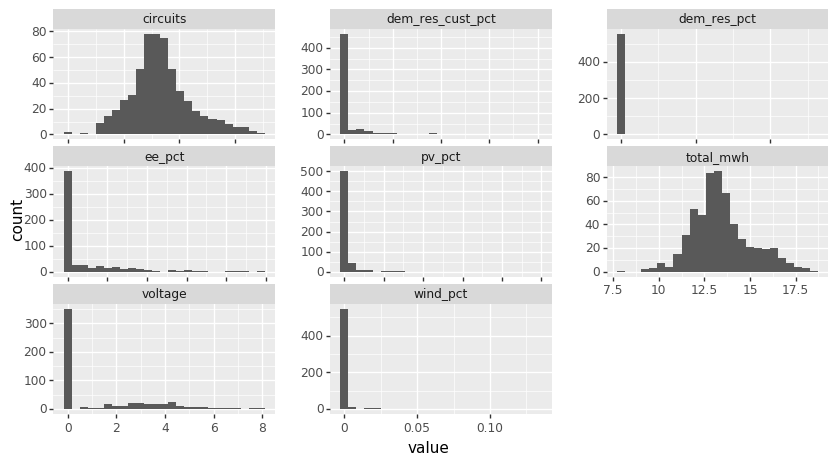

<ggplot: (8765466748769)>

In [535]:
d = train_X_log.iloc[:,:8]

(
    ggplot(d.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

### Median Method

In [33]:
# all columns before the dummies
train_X.iloc[:,:8].columns

Index(['total_mwh', 'circuits', 'voltage', 'pv_pct', 'wind_pct', 'ee_pct',
       'dem_res_pct', 'dem_res_cust_pct'],
      dtype='object')

In [34]:
# Version 2 use the medians and log total_mwh and circuits because that works
df_19_med = df_19.copy() 

# total_mwh and circuits logged
df_19_med['total_mwh'] = np.log(df_19['total_mwh'])
df_19_med['circuits'] = np.log(df_19['circuits'])

# voltage pct
median_voltage_pct = df_19.loc[df_19_med['voltage'] > 0,'voltage'].median()
df_19_med['voltage'] =  np.where(df_19_med['voltage']==0,0,np.where(df_19_med['voltage'] <= median_voltage_pct,1,2))

# pv pct
median_pv_pct = df_19.loc[df_19_med['pv_pct'] > 0,'pv_pct'].median()
df_19_med['pv_pct'] =  np.where(df_19_med['pv_pct']==0,0,np.where(df_19_med['pv_pct'] <= median_pv_pct,1,2))

# wind pct
median_wind_pct = df_19_med.loc[df_19_med['wind_pct'] > 0,'wind_pct'].median()
df_19_med['wind_pct'] =  np.where(df_19_med['wind_pct']==0,0,np.where(df_19_med['wind_pct'] <= median_wind_pct,1,2))

# energy efficiency pct
median_ee_pct = df_19_med.loc[df_19_med['ee_pct'] > 0,'ee_pct'].median()
df_19_med['ee_pct'] =  np.where(df_19_med['ee_pct']==0,0,np.where(df_19_med['ee_pct'] <= median_ee_pct,1,2))

# demand response pct
median_dr_pct = df_19_med.loc[df_19_med['dem_res_pct'] > 0,'dem_res_pct'].median()
df_19_med['dem_res_pct'] =  np.where(df_19_med['dem_res_pct']==0,0,np.where(df_19_med['dem_res_pct'] <= median_dr_pct,1,2))

# demand response customer pct
median_drc_pct = df_19_med.loc[df_19_med['dem_res_cust_pct'] > 0,'dem_res_cust_pct'].median()
df_19_med['dem_res_cust_pct'] =  np.where(df_19_med['dem_res_cust_pct']==0,0,np.where(df_19_med['dem_res_cust_pct'] <= median_drc_pct,1,2))

In [35]:
y = df_19_med['saidi_nomed']
X = df_19_med.drop(columns=['no','name','total_cust','ba',
                       'saidi_nomed','saifi_nomed', 'caidi_nomed',
                       'gen_mwh', 'purchase_mwh', 
                       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
                       'dem_res_customers', 'dem_res_mwh',
                        'nm_pct'])
train_X_med, test_X_med, train_y_med, test_y_med = train_test_split(X,y,test_size=.25,random_state=1997)

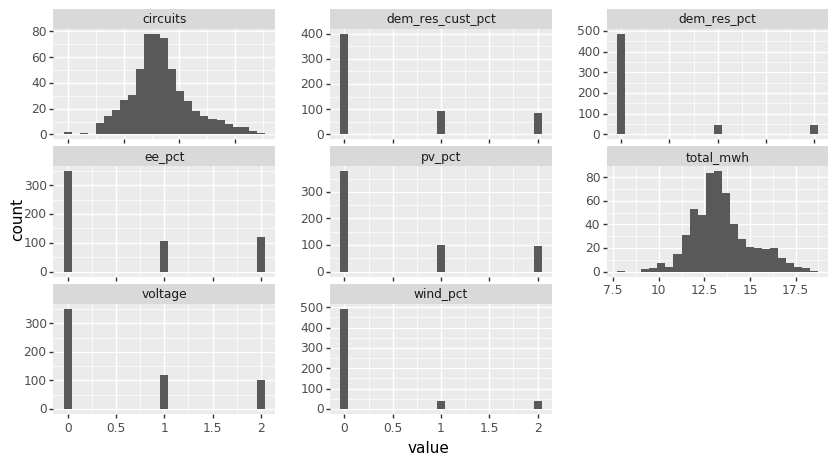

<ggplot: (8771483520537)>

In [36]:
d = train_X_med.iloc[:,:8]

(
    ggplot(d.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

## Sqrt Method

In [214]:
# Version 4 use sqrt transform 
# df_19_sqrt = df_19.copy()

# df_19_sqrt['pv_pct'] = np.sqrt(df_19_sqrt['pv_pct'])
# df_19_sqrt['wind_pct'] = np.sqrt(df_19_sqrt['wind_pct'])
# df_19_sqrt['ee_pct'] = np.sqrt(df_19_sqrt['ee_pct'])
# df_19_sqrt['dem_res_pct'] = np.sqrt(df_19_sqrt['dem_res_pct'])

In [215]:
# y = df_19_sqrt['saidi_nomed']
# X = df_19_sqrt[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]
# train_X_sqrt, test_X_sqrt, train_y_sqrt, test_y_sqrt = train_test_split(X,y,test_size=.25,random_state=1997)

In [596]:
# (
#     ggplot(train_X_sqrt.melt(),aes(x="value")) +
#     geom_histogram(bins=25) +
#     facet_wrap("variable",scales='free') +
#     theme(figure_size=(10,5),
#           subplots_adjust={'wspace':0.25})
# )

In [225]:
# # Version 5 use box-cox
# df_19_box = df_19.copy()

# df_19_box['pv_pct'] = stats.boxcox(df_19_box['pv_pct'] + 1)[0]
# df_19_box['wind_pct'] = stats.boxcox(df_19_box['wind_pct'] + 1)[0]
# df_19_box['ee_pct'] = stats.boxcox(df_19_box['ee_pct']+ 1)[0]
# df_19_box['dem_res_pct'] = stats.boxcox(df_19_box['dem_res_pct'] + 1)[0]

In [226]:
# y = df_19_box['saidi_nomed']
# X = df_19_box[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]
# train_X_box, test_X_box, train_y_box, test_y_box = train_test_split(X,y,test_size=.25,random_state=1997)

In [597]:
# (
#     ggplot(train_X_box.melt(),aes(x="value")) +
#     geom_histogram(bins=25) +
#     facet_wrap("variable",scales='free') +
#     theme(figure_size=(10,5),
#           subplots_adjust={'wspace':0.25})
# )

# Compare skews

In [550]:
pd.DataFrame({
'OG': train_X.skew(),
'log':train_X_log.skew(),
'med':train_X_med.skew()
#'sqrt':train_X_sqrt.skew(),
#'box-cox':train_X_box.skew()
})

,OG,log,med
total_mwh,6.667333,0.477582,0.477582
circuits,5.584260,0.517052,0.517052
voltage,7.975704,1.173707,0.924391
pv_pct,18.323248,8.764684,1.083670
wind_pct,9.511568,9.271155,2.503223
...,...,...,...
VT,23.979158,23.979158,23.979158
WA,6.188382,6.188382,6.188382
WI,5.569176,5.569176,5.569176
WV,9.660773,9.660773,9.660773


#### Best for each:

- total_mwh and circuits: Log (makes the most sense and roughly normal distribution)
- everything else: Med

## Manual Machine Learning

### Preprocess

In [37]:
# Let's put everything on a scale between 1 and 0 
scaler = pp.MinMaxScaler()
col_names = list(train_X_med) # save the column names because the scaler makes it into a numpy array
train_X = scaler.fit_transform(train_X_med)

In [38]:
# Convert back into data frame with the column names
train_X_med = pd.DataFrame(train_X_med,columns=col_names)

In [39]:
train_X_med.describe()

,total_mwh,circuits,voltage,pv_pct,wind_pct,ee_pct,dem_res_pct,dem_res_cust_pct,AK,ECAR,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
count,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.0,...,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000
mean,13.416082,4.169427,0.566957,0.513043,0.213913,0.603478,0.231304,0.457391,0.001739,0.0,...,0.020870,0.045217,0.055652,0.013913,0.022609,0.001739,0.024348,0.029565,0.010435,0.012174
std,1.620976,1.365777,0.777708,0.766971,0.557947,0.811066,0.575693,0.740452,0.041703,0.0,...,0.143072,0.207962,0.229448,0.117232,0.148782,0.041703,0.154261,0.169532,0.101705,0.109757
min,7.947679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.332589,3.384247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.174305,4.043051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.201848,4.820282,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.533614,8.633909,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
train_y_med.describe()

count     575.000000
mean      141.710558
std       146.387884
min         1.394000
25%        55.045500
50%        99.800000
75%       175.702000
max      1239.300000
Name: saidi_nomed, dtype: float64

## Modeling - Attempt 2

In [605]:
# EVERYTHING must hold constant other than the algorithm because we're looking for the best algorithm 
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111) # make sure splits are same with random state

In [606]:
type(fold_generator)

sklearn.model_selection._split.KFold

In [607]:
# just MSE but negative, used by sklearn
use_metrics = ["neg_mean_squared_error"] 

### Linear Model

In [608]:
lm_scores = cross_validate(LM(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [610]:
mod = LM()

In [611]:
mod.fit(train_X_med, train_y_med)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [612]:
mod.coef_

array([-3.65019767e+01,  2.96211942e+01,  1.81238153e+00,  6.11080707e+00,
        2.59654262e+01, -3.97535696e+00,  1.64606168e+01, -4.63162702e+00,
        7.22017579e+14,  8.81129015e+15, -3.72485502e+01,  6.28936479e+14,
        6.94596611e+01,  7.65019275e+01, -2.55922078e+01, -8.08640115e+01,
        6.38860394e+01,  1.88809151e+02, -1.37120806e+02, -2.24616389e+02,
        6.41119893e+01,  2.25389299e+01, -7.56842836e+01,  2.13045124e+02,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  9.30810999e+13,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  

### KNN

In [613]:
knn_scores = cross_validate(KNN(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [614]:
KNN().get_params

<bound method BaseEstimator.get_params of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')>

### Decision Tree

In [615]:
dt_scores = cross_validate(DTree(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

#### Side Note: Plotting a Decision Tree
First, a quick side note on the decision trees. When we built a tree from scratch, we discussed looking at the **decision rules** of the tree. There is a very straight forward way of doing this in `sklearn`.

In [616]:
# grab the column names
col_names = train_X_med.columns

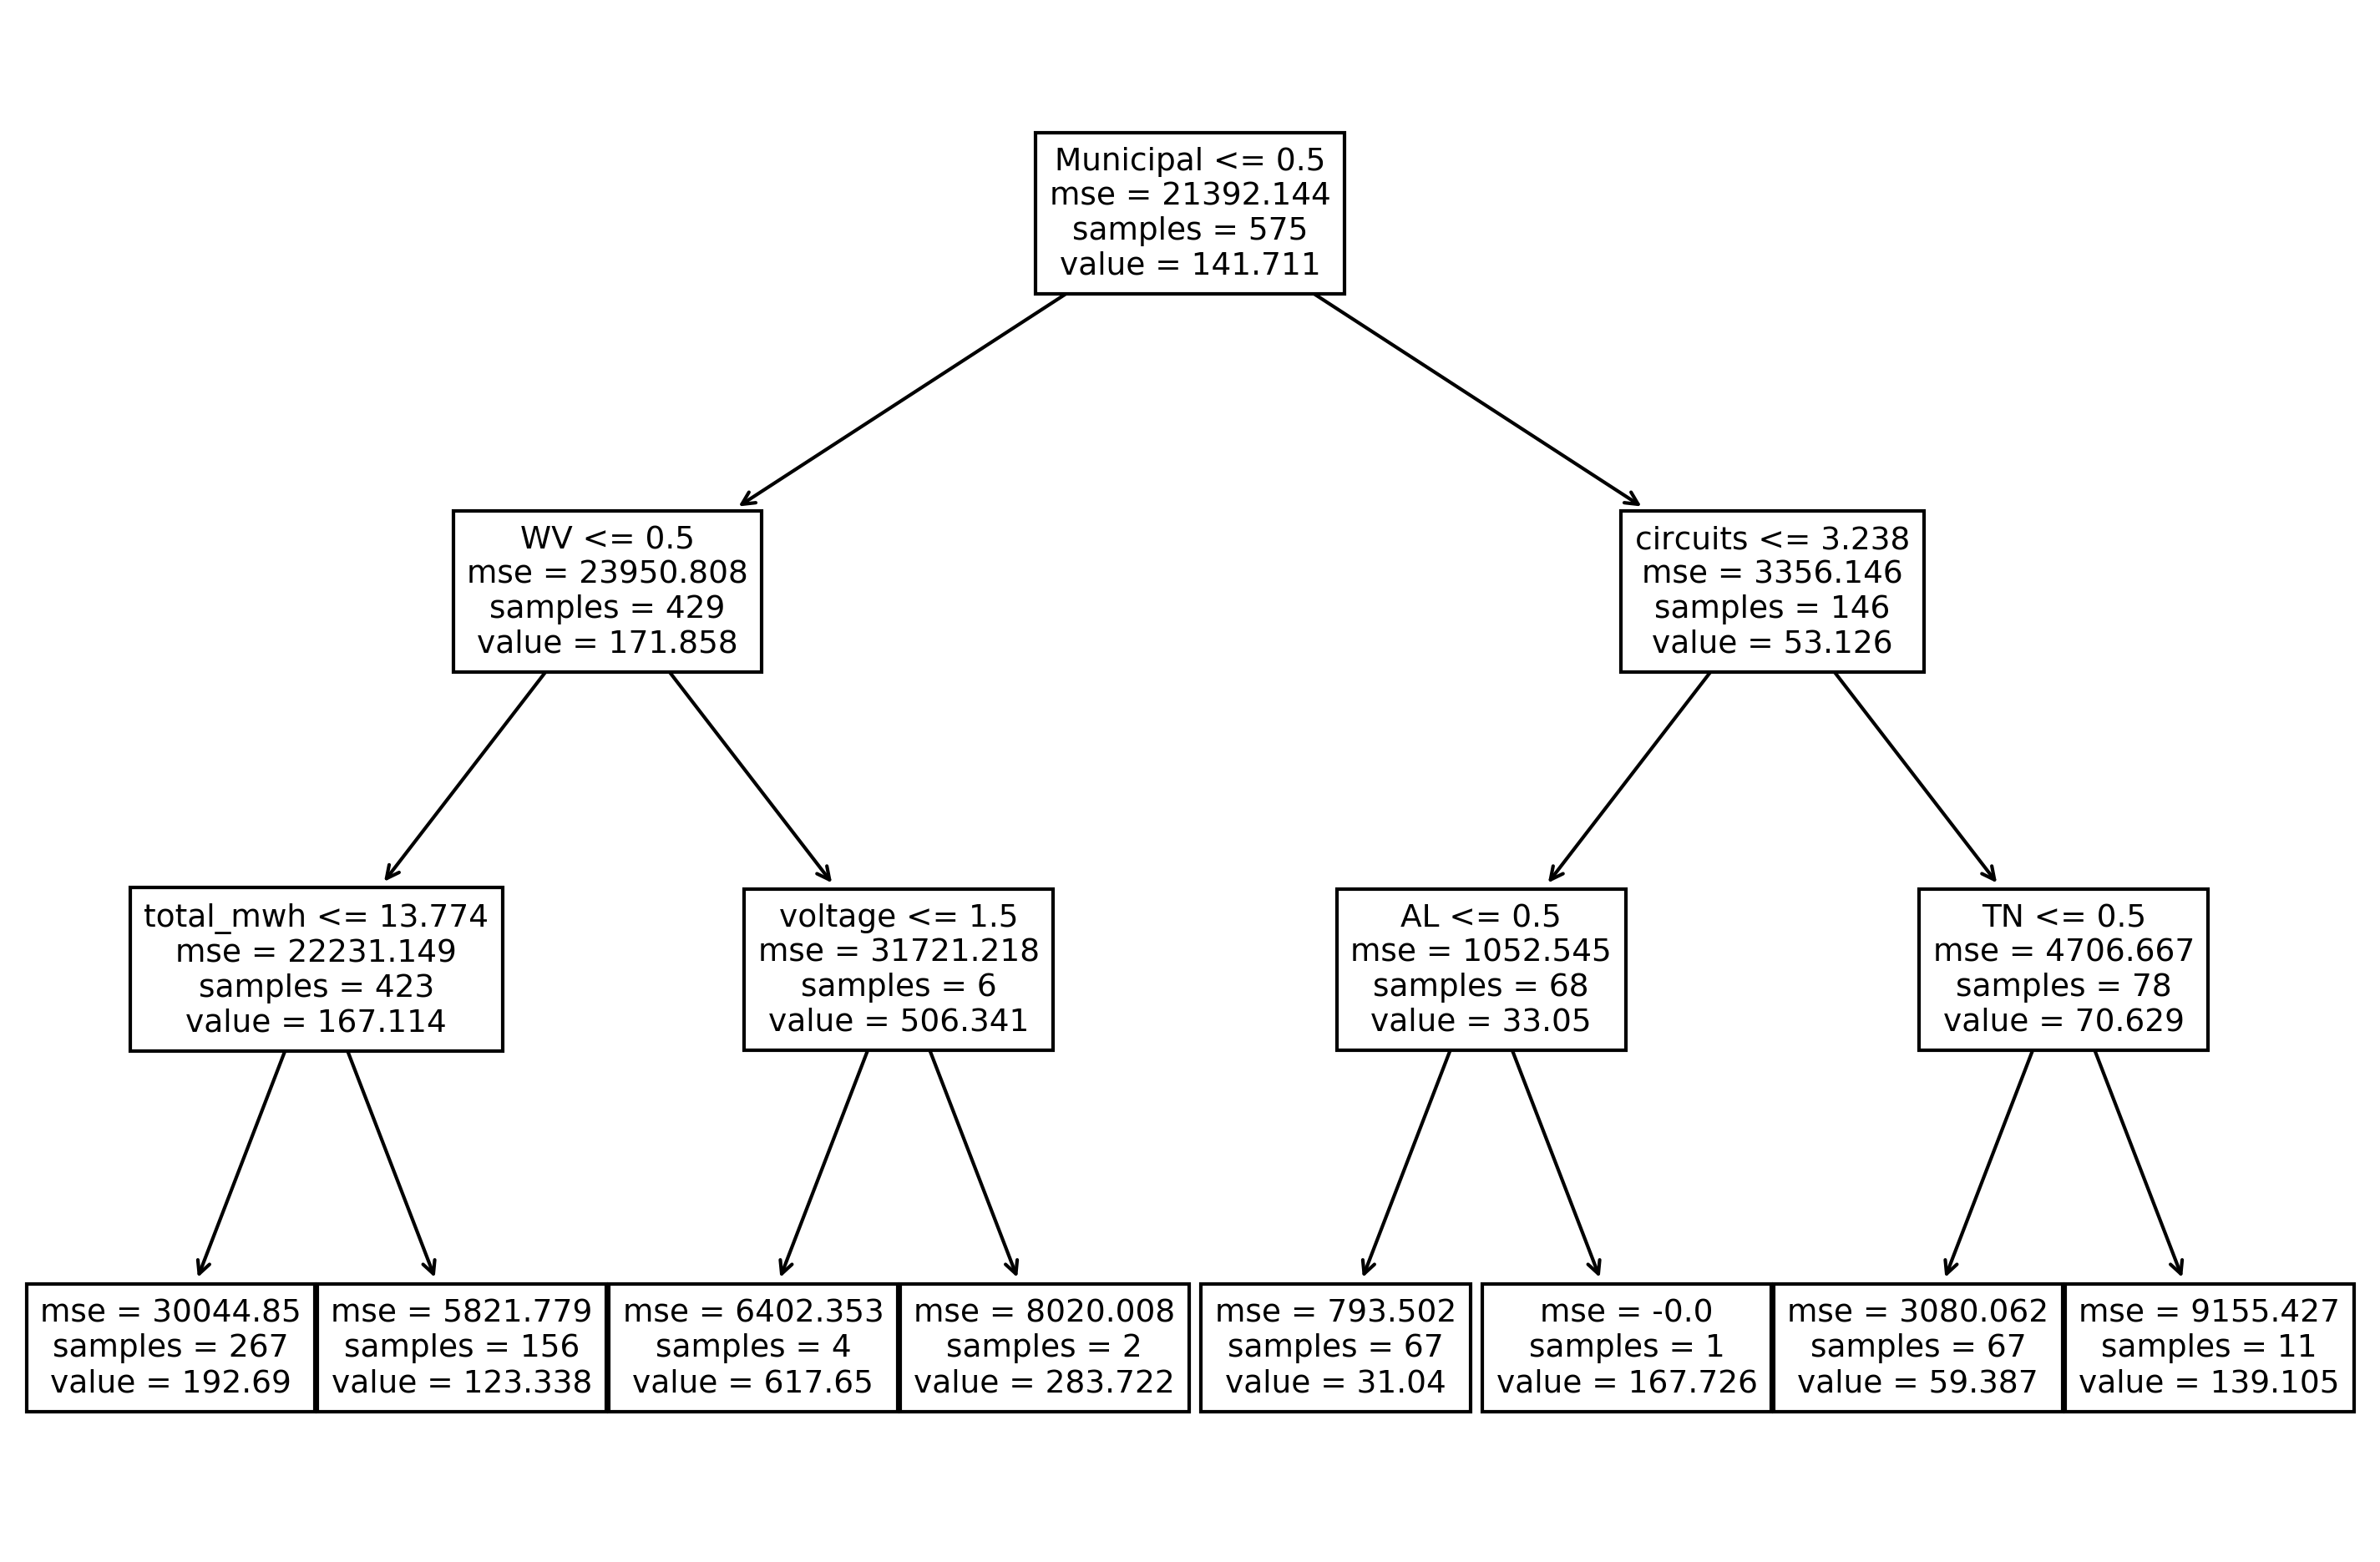

In [617]:
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X_med,train_y_med) # Fit the model

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=9)

### Bagging

In [618]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

### Random Forest

In [619]:
# takes longer, because 1000 models 
rf_scores = cross_validate(RF(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [620]:
RF().get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

## Compare models

In [621]:
# Collect all the metrics we care about as a dictionary 
# name them by which method we used
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,1.076125e+26
1,lm,3.371013e+27
2,lm,1.120779e+29
3,lm,1.340202e+27
4,lm,9.140168e+26
5,knn,2.502539e+04
6,knn,2.792638e+04
7,knn,1.385562e+04
8,knn,2.035200e+04
9,knn,1.259813e+04


In [712]:
train_X_med

,total_mwh,circuits,voltage,pv_pct,wind_pct,ee_pct,dem_res_pct,dem_res_cust_pct,AK,ECAR,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
114,15.222755,5.293305,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218,13.916759,4.219508,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
409,13.463900,3.401197,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
345,13.753692,4.418841,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
325,13.463119,4.521789,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,14.571803,6.991177,2,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
247,12.754061,3.610918,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
656,9.086024,0.693147,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304,15.525395,5.455321,0,1,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


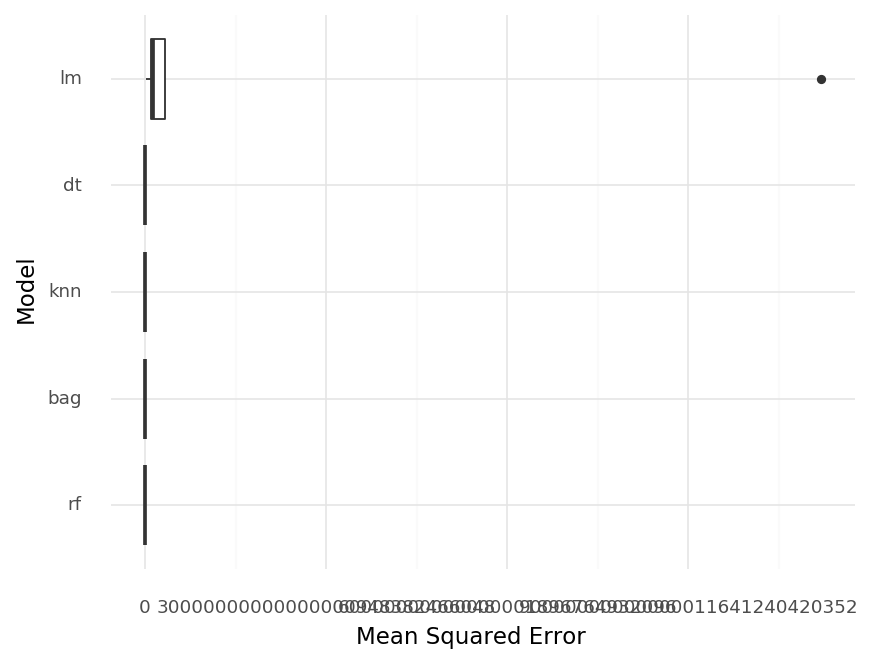

<ggplot: (8765469531737)>

In [633]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

In [599]:
## let's figure out how to visualize a random forest

## Attempt 2: Hyperparameter tuning

#### Tune KNN

In [662]:
set_k = dict()
for k in [15,20,23,25]:
    score = cross_validate(KNN(n_neighbors=k),
                           train_X_med,train_y_med, 
                           cv = fold_generator, 
                           scoring =use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()
 
set_k
## see how they are negative? that's how sklearn does MSE

{15: -19186.087376006406,
 20: -18832.384721349612,
 23: -18641.026671132822,
 25: -18768.16506559353}

In [663]:
knn_tune_params = {'n_neighbors':[15,20,23,25]}

In [664]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [665]:
tune_knn.fit(train_X_med,train_y_med)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid={'n_neighbors': [15, 20, 23, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [666]:
tune_knn.best_params_

{'n_neighbors': 23}

In [667]:
tune_knn.best_score_

-18641.026671132822

For KNN, I should use these options. 23 is best N.

#### Tune Decision Tree

In [668]:
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [156]:
tune_dt.fit(train_X_med,train_y_med)

NameError: name 'tune_dt' is not defined

In [670]:
tune_dt.best_params_

{'max_depth': 1}

In [671]:
tune_dt.best_score_

-18762.109328058337

This is odd, but I guess max depth of 1 is best for decision tree.

#### Tune Random Forest

In [157]:
rf_params = {'n_estimators':[1000,1250], 'max_depth': [10,15,20], 'max_features': [5,10]} 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4, 
                        verbose = 10)

In [150]:
tune_rf.fit(train_X_med,train_y_med)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   47.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  4.7min
[Parallel(

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             ve

In [153]:
tune_rf.best_params_

{'max_depth': 10, 'max_features': 10, 'n_estimators': 1250}

In [154]:
tune_rf.best_score_

-16849.554643927928

### RF feature importance

In [160]:
rf = RF(n_estimators=1250, max_features=10, max_depth=10)

In [162]:
rf.fit(train_X_med,train_y_med)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1250, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [236]:
sorted_idx = rf.feature_importances_.argsort()

In [251]:
sorted_idx[-10:]

array([ 4, 57, 48, 66,  3, 20, 72, 22,  1,  0])

In [238]:
train_X_med.columns[sorted_idx]

Index(['ECAR', 'AK', 'HI', 'DE', 'DC', 'HI', 'LA', 'RI', 'MD', 'ID', 'NJ',
       'NH', 'VT', 'CT', 'FRCC', 'ND', 'PA', 'MISO', 'NV', 'CO', 'OR', 'ME',
       'IL', 'NM', 'MO', 'SC', 'WI', 'GA', 'AZ', 'NE', 'IA',
       'Political Subdivision', 'MA', 'AR', 'WA', 'CA', 'IN', 'KS', 'OK', 'MT',
       'KY', 'NC', 'AL', 'FL', 'TN', 'MI', 'OH', 'WY', 'WECC', 'MN', 'SERC',
       'VA', 'TRE', 'UT', 'RFC', 'NPCC', 'dem_res_pct', 'MRO',
       'Investor Owned', 'SD', 'SPP', 'voltage', 'dem_res_cust_pct', 'ee_pct',
       'wind_pct', 'NY', 'MS', 'TX', 'pv_pct', 'Cooperative', 'WV',
       'Municipal', 'circuits', 'total_mwh'],
      dtype='object')

<BarContainer object of 15 artists>

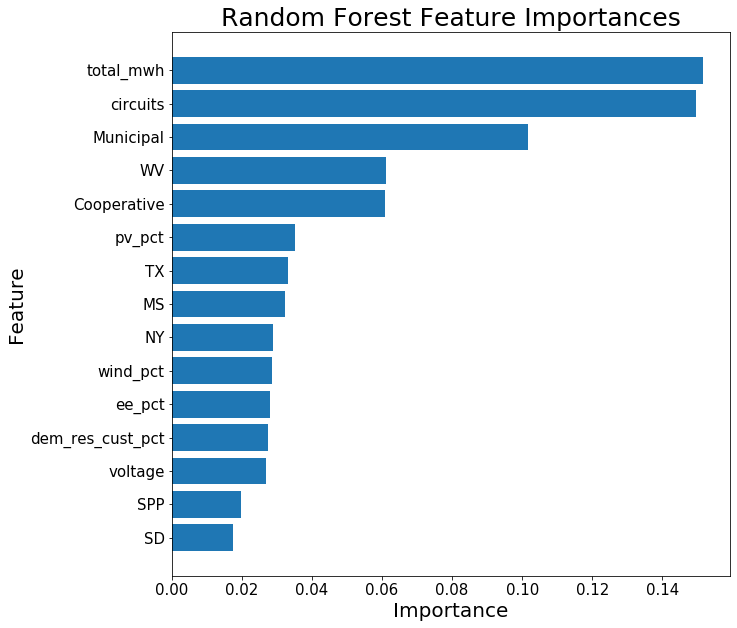

In [258]:
plt.figure(figsize=(10, 10))
plt.title("Random Forest Feature Importances", fontsize=25)
plt.ylabel("Feature", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Importance", fontsize=20)
plt.barh(train_X_med.columns[sorted_idx[-15:]], rf.feature_importances_[sorted_idx[-15:]])

# Build machine learning pipeline

In [4]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

In [5]:
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(),  make_column_selector(dtype_exclude=None))])

In [6]:
# initialize our pipeline 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

In [7]:
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param, use double underscore to separate model from its parameter__
    {'model' : [KNN()],
     'model__n_neighbors':[15,20,23,25]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[1225,1250,1275]},
]

In [8]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4,
                      verbose = 10)

## Attempt 2

In [41]:
search.fit(train_X_med,train_y_med)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1852s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1703s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Batch computation too slow (2.6394s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done 126 tasks      | elapsed:   56.4s
[Parallel(n_jobs=4)]: Done 145 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  2.2min
[Paralle

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         <sklearn.compose._column_trans

In [42]:
search.best_score_ # Mean out-of-sample (CV) error

-17891.99274999949

In [43]:
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1225, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 3,
 'model__n_estimators': 1225}

In [140]:
rf_mod = search.best_estimator_

In [44]:
pred_y_med = search.predict(test_X_med)

In [259]:
m.mean_squared_error(test_y_med,pred_y_med)


13611.018293399402

In [260]:
m.r2_score(test_y_med,pred_y_med)


0.11630208589652957

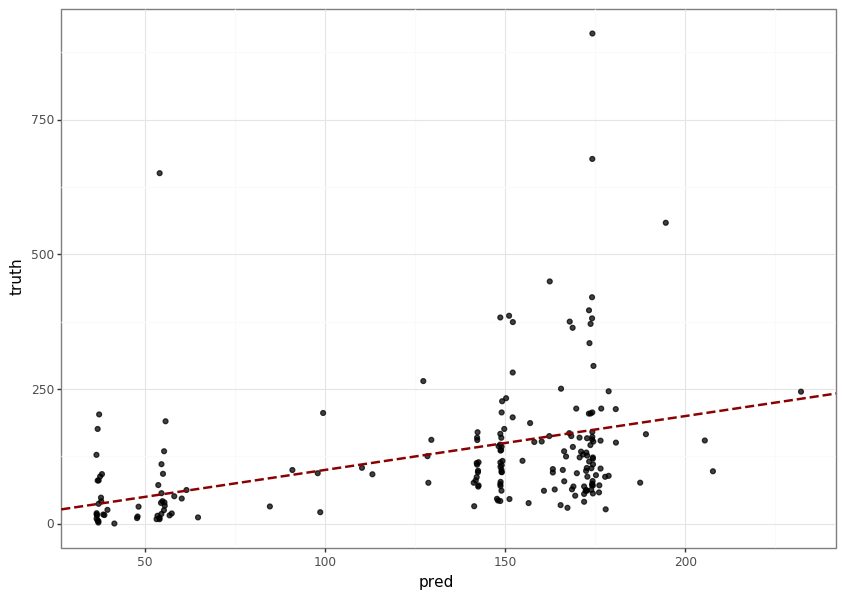

<ggplot: (8771483541213)>

In [47]:
# see how in the pipeline we preprocessed X so it is fixed beforehand and we can make sense of the predictions 
(
    ggplot(pd.DataFrame(dict(pred=pred_y_med,truth=test_y_med)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

In [699]:
# Our RMSE is about the same as one standard deviation
test_y_med.describe()

count    192.000000
mean     129.998693
std      124.430637
min        0.655000
25%       58.015000
50%       99.240000
75%      159.112500
max      909.710000
Name: saidi_nomed, dtype: float64

In [48]:
rf_mod = search.best_estimator_

## Attempt 2: Model Interpretation

In [49]:
perm_train = PermutationImportance(rf_mod,
                                   n_iter=5,random_state=123)

In [50]:
perm_train.fit(train_X_med,train_y_med)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('pre_process',
                                                 ColumnTransformer(n_jobs=None,
                                                                   remainder='drop',
                                                                   sparse_threshold=0.3,
                                                                   transformer_weights=None,
                                                                   transformers=[('num',
                                                                                  MinMaxScaler(copy=True,
                                                                                               feature_range=(0,
                                                                                                              1)),
                                                                             

In [71]:
vi = eli5.explain_weights_df(perm_train,feature_names = list(train_X_med))

In [72]:
# Generate intervals
vi['low'] = vi['weight'] - 2*vi['std']
vi['high'] = vi['weight'] + 2*vi['std']

# But in order from most to least important
vi = vi.sort_values(by="weight",ascending=False).reset_index(drop=True).head(15)
vi

,feature,weight,std,low,high
0,Municipal,0.296700,0.028890,2.389191e-01,0.354481
1,WV,0.080794,0.008613,6.356884e-02,0.098020
2,total_mwh,0.057952,0.005267,4.741854e-02,0.068486
3,MS,0.027898,0.002449,2.299964e-02,0.032795
4,TX,0.023090,0.001762,1.956525e-02,0.026614
5,circuits,0.022752,0.000704,2.134405e-02,0.024161
6,NY,0.013552,0.007664,-1.776433e-03,0.028880
7,SPP,0.008977,0.001093,6.790415e-03,0.011163
8,TN,0.006487,0.001503,3.480984e-03,0.009492
9,dem_res_cust_pct,0.005264,0.000705,3.854572e-03,0.006673


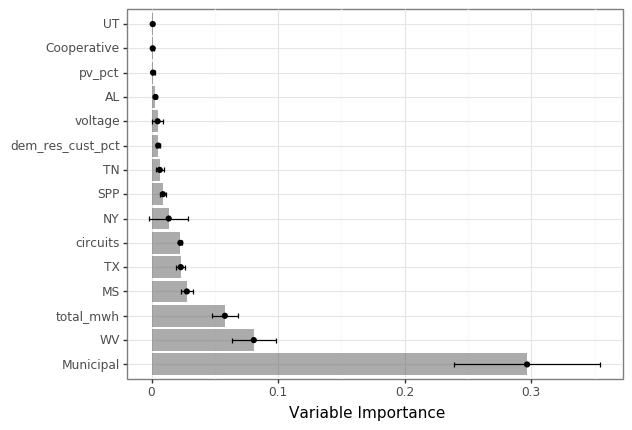

<ggplot: (8771409017845)>

In [136]:
# Plot
(
    ggplot(vi,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi.feature.tolist()) +
    coord_flip() +
    labs(y="Variable Importance",x="")
)

In [79]:
train_X_med.columns

Index(['total_mwh', 'circuits', 'voltage', 'pv_pct', 'wind_pct', 'ee_pct',
       'dem_res_pct', 'dem_res_cust_pct', 'AK', 'ECAR', 'FRCC', 'HI', 'MISO',
       'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC', 'Cooperative',
       'Investor Owned', 'Municipal', 'Political Subdivision', 'AL', 'AR',
       'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL',
       'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT',
       'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA',
       'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

ValueError: feature_names should not contain duplicates.

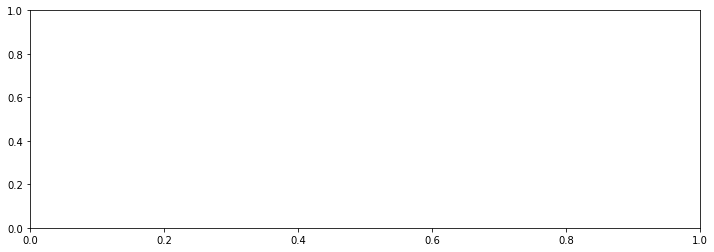

In [137]:
# Target specific features
features = ['Municipal','total_mwh', 'circuits']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X_med, features,n_cols=6,
    n_jobs=4, grid_resolution=30,ax=ax)

In [99]:
pr_y_med = rf_mod.predict(train_X_med)
pr_y_med

array([149.05239048,  82.93822113,  53.4118673 , 155.29609645,
       167.01057813, 144.0471935 , 166.62693643,  36.82613574,
       142.51016715,  51.94103773, 166.43074527, 163.0417981 ,
        53.6876655 , 156.24686859,  37.16954352,  54.98941029,
       170.10514335, 179.71998376,  49.17776612, 149.00840581,
       164.25614738, 150.10835679, 142.27429654, 149.80320218,
       161.3894689 , 162.08427767, 112.06796728,  58.11685612,
        38.71635815, 172.07300696,  36.67817377, 173.65861985,
        54.62701001, 195.98992061, 164.25614738,  37.39982441,
        54.93140608,  37.23061192, 172.4819972 , 169.62462168,
        37.21478043, 143.64756371, 171.23786141, 110.75111297,
       149.82235105,  52.24754748,  55.60790392, 161.64142396,
       112.10819334, 141.68258652, 148.95590109,  60.47939194,
       165.60534676, 173.95235928, 160.97811247, 185.74505467,
       166.78995045, 167.7214602 , 149.05239048, 149.00029896,
       169.45251924, 165.23376254,  37.28109192, 173.39

In [101]:
surrogate_model = DTree(max_depth=3)
surrogate_model.fit(train_X_med,pr_y_med)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [102]:
m.r2_score(pr_y_med,surrogate_model.predict(train_X_med)).round(2)

0.92

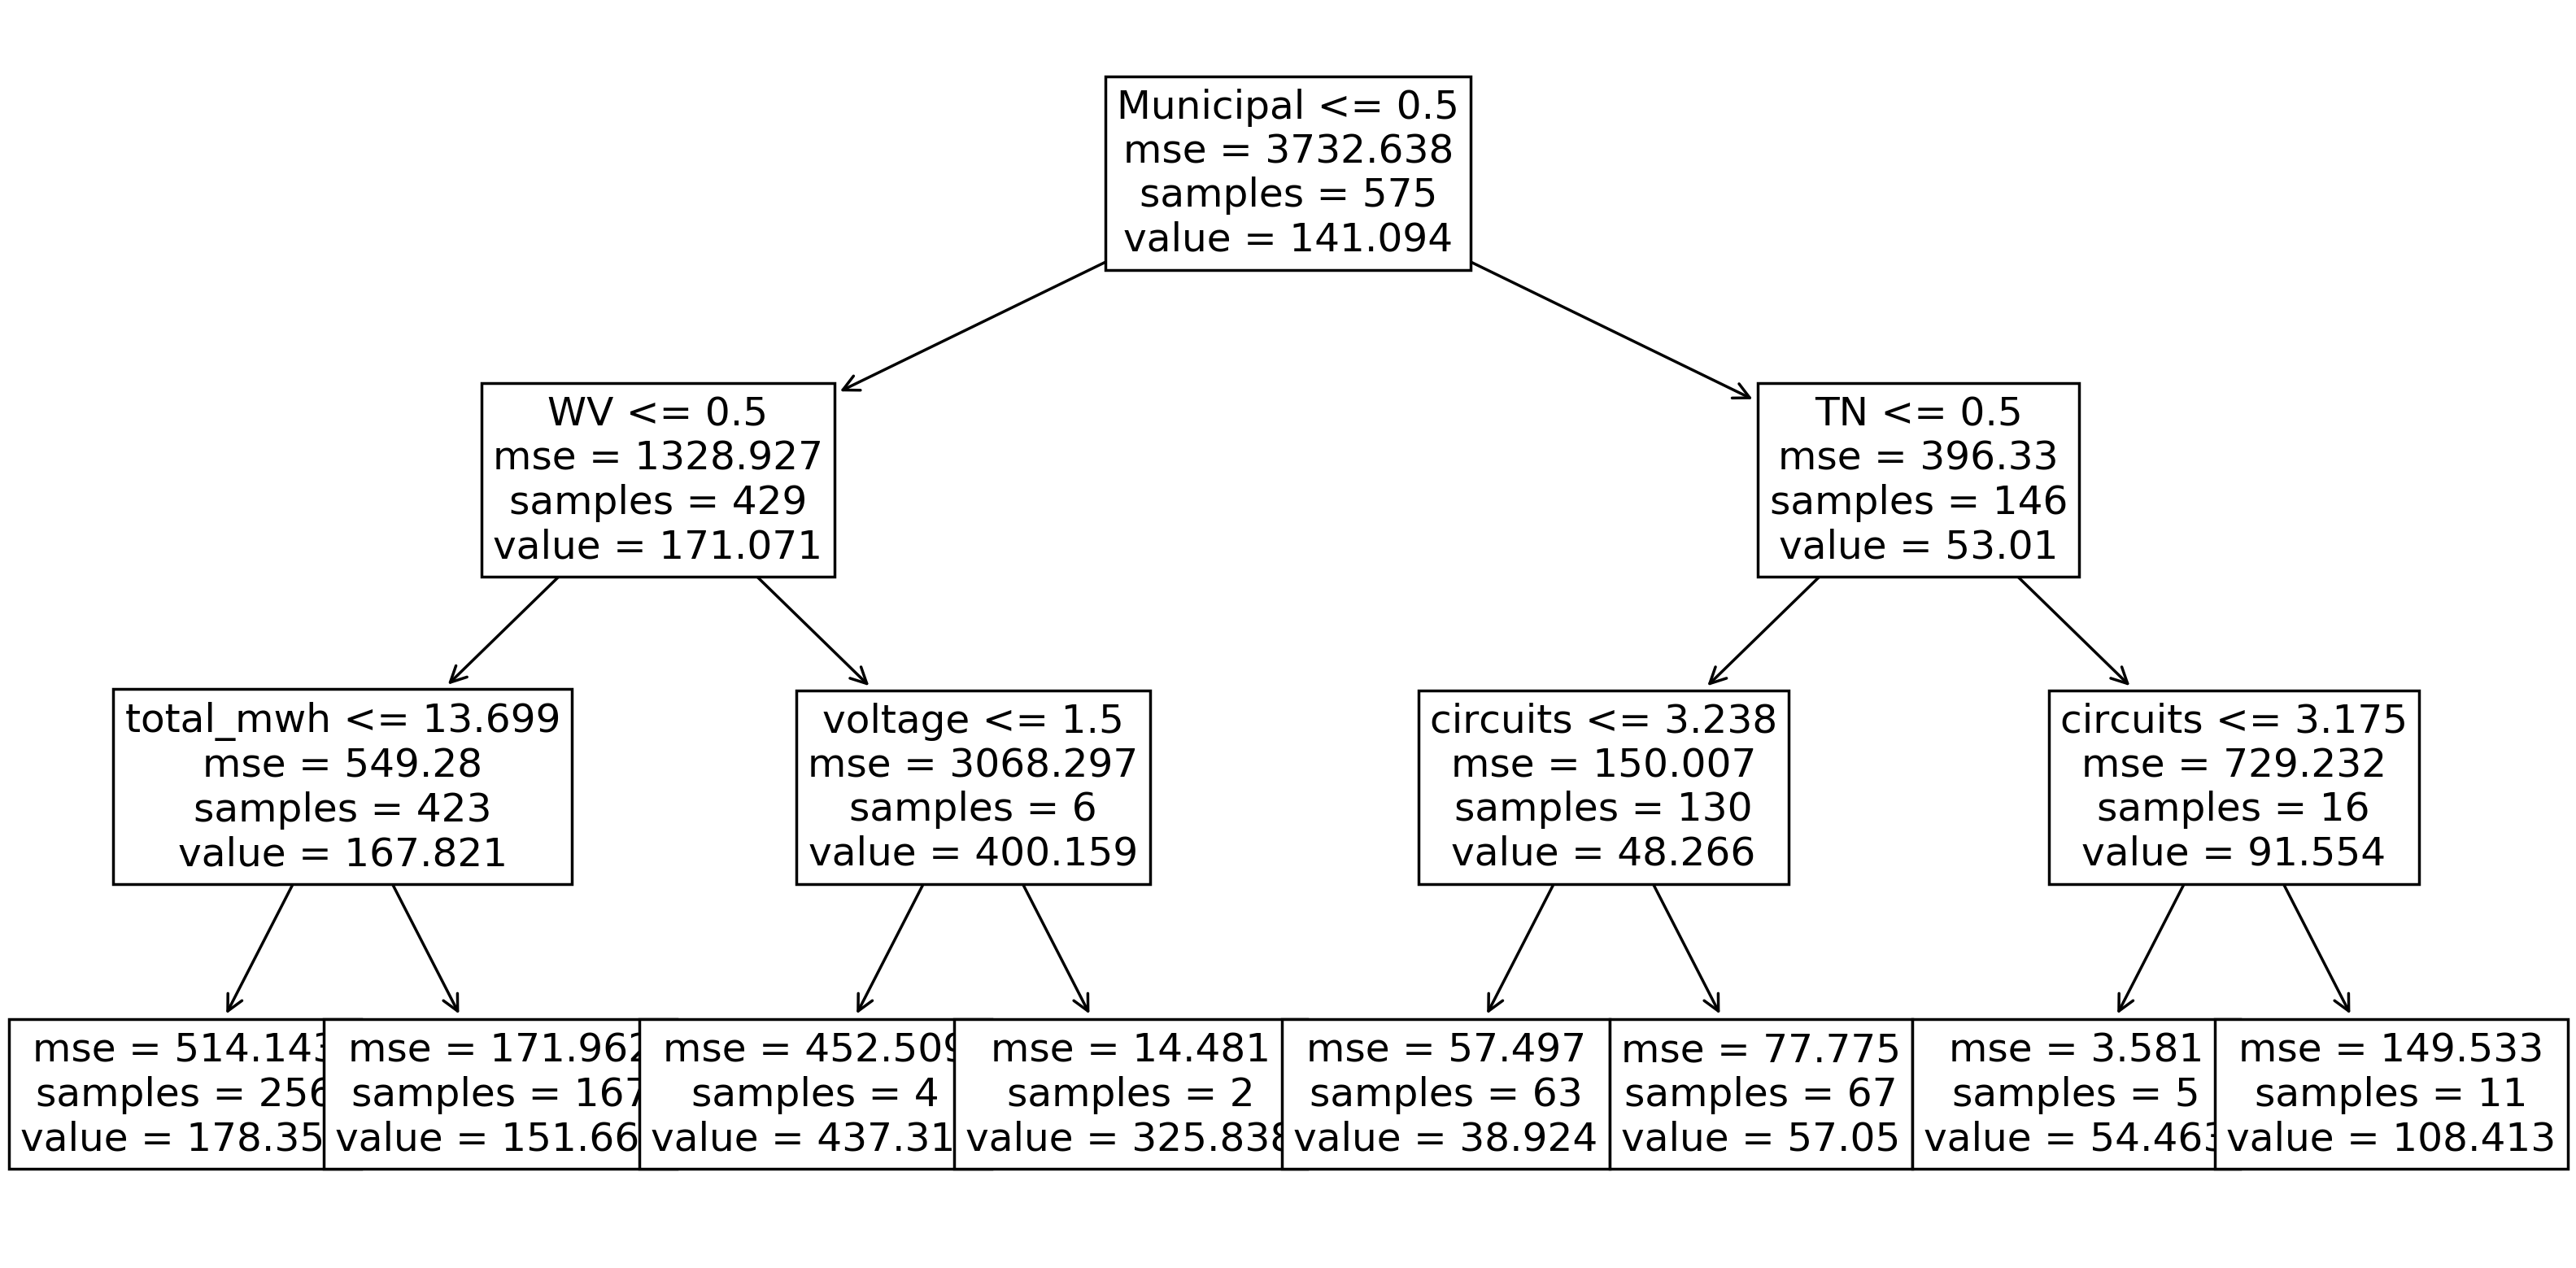

In [108]:
# Plot the tree
plt.figure(figsize=(16,8),dpi=250)
rules = tree.plot_tree(surrogate_model,feature_names=train_X_med.columns,fontsize=14)

# Attempt 1

### Log Method Results

In [ ]:
# log method
search.fit(train_X,train_y)

In [112]:
search.best_score_ # Mean out-of-sample (CV) error

-21082.61436550224

In [113]:
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1250, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 3,
 'model__n_estimators': 1250}

In [114]:
pred_y = search.predict(test_X)

In [115]:
m.mean_squared_error(test_y,pred_y)


15986.957948610108

In [116]:
m.r2_score(test_y,pred_y)


-0.037956241591254214

### Median Method

In [ ]:
search.fit(train_X,train_y)

In [123]:
search.best_score_ # Mean out-of-sample (CV) error

-21120.39481983883

In [124]:
pred_y = search.predict(test_X)

In [125]:
m.mean_squared_error(test_y,pred_y)

16057.475013154188

In [126]:
m.r2_score(test_y,pred_y)


-0.04253457522530124

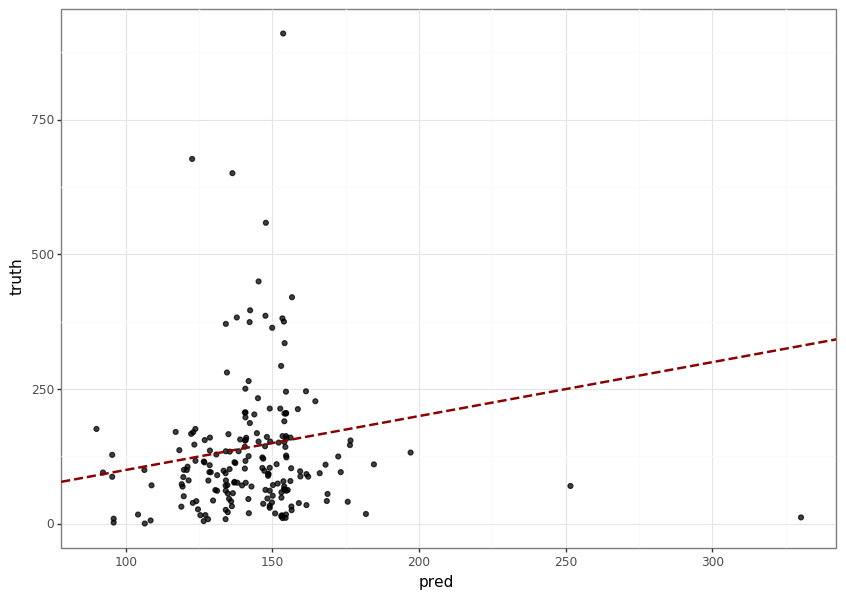

<ggplot: (8765491538285)>

In [117]:
# see how in the pipeline we preprocessed X so it is fixed beforehand and we can make sense of the predictions 
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

## Retry while doing preprocessing scaler overtly

In [154]:
y = df_19['saidi_nomed']
X = df_19[['total_cust','nm_pct','ee_pct','dem_res_pct']]

In [155]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [144]:
print(train_X.shape[0]/df_19.shape[0])
print(test_X.shape[0]/df_19.shape[0])

0.7496740547588006
0.2503259452411995


In [152]:
# Plot the continuous variables 
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

AttributeError: 'numpy.ndarray' object has no attribute 'melt'

In [141]:
# Version 3 just log everything
df_19['total_cust'] = np.log(df_19['total_cust'])
df_19['nm_pct'] = np.log(df_19['nm_pct'] + 1)
df_19['ee_pct'] = np.log(df_19['ee_pct'] + 1)
df_19['dem_res_pct'] = np.log(df_19['dem_res_pct'] + 1)

In [157]:
scaler = pp.StandardScaler()

In [158]:
scaler = scaler.fit(train_X)


In [160]:
X_scaled = scaler.transform(train_X)


In [162]:
X_scaled.mean(axis=0)

array([ 2.47145299e-16, -1.39019231e-17, -1.85358975e-17,  9.26794873e-18])

## Unresolved

## Discard

In [449]:
# rename column heading
# nerc_dummies.rename(columns={"0": "None"})